In [22]:
pip install -U gdown -q

Note: you may need to restart the kernel to use updated packages.


In [23]:
import zipfile
from io import BytesIO

import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from os import listdir
from os.path import isfile, join

In [36]:
RESOLUTION = 224
PATCH_SIZE = 16

In [53]:
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)


def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)

    # Resize the image using bicubic interpolation.
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # Crop the image.
    image = crop_layer(image)

    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)

    return image.numpy()
def load_image_local(i, model_type):
    # Credit: Willi Gierke
    mypath = '/Users/jadenstryker/Downloads/language_data-3/en/3.png'
    #onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    #filFiles = [f for f in onlyfiles if 'filter' in f]
    #moonyFiles = [f for f in onlyfiles if 'test' in f]
    di = mypath
    print(di)
    image = Image.open(di).convert('RGB')
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image
def load_image_name(name, model_type):
    mypath = '/Users/jadenstryker/Downloads/language_data-3/en.png'
    image = Image.open(mypath).convert('RGB')
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image

def load_image_from_url(url, model_type):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image

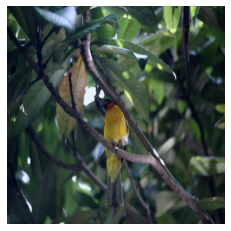

In [38]:
# ImageNet-1k label mapping file and load it.

mapping_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)

with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="original_vit")

plt.imshow(image)
plt.axis("off")
plt.show()

In [39]:
!pip install --upgrade --no-cache-dir gdown

Requirement already up-to-date: gdown in /Users/jadenstryker/opt/anaconda3/lib/python3.8/site-packages (4.6.0)


In [40]:
def get_tfhub_model(model_url: str) -> tf.keras.Model:
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    hub_module = hub.KerasLayer(model_url)
    outputs, attention_weights = hub_module(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_gdrive_model(model_id: str) -> tf.keras.Model:
    model_path = gdown.download(id=model_id, quiet=False)
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall()
    model_name = model_path.split(".")[0]
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_gdrive_model(model_id: str) -> tf.keras.Model:
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall()
    model_name = model_path.split(".")[0]
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])

def get_model(url_or_id):
    if "https" in url_or_id:
        loaded_model = get_tfhub_model(url_or_id)
    else:
        loaded_model = get_gdrive_model(url_or_id)
    return loaded_model


model = get_model("1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ")
model = model.load_state_dict(torch.load('model_vit.pth'))
print("Model loaded.")

Model loaded.


In [ ]:
print(int(np.argmax(predictions)))
predictions[0][153]
#153 dog
#980 moony dog

In [ ]:
print(f'mean: {np.mean(predictions[0])}')
import scipy.stats as stats
print(f'zscore: {stats.zscore(predictions[0], ddof=1)[980]}')

#the zscore for a volcano prediction is 3.66 for volcano, and 1.637 for dog
#the zscore for a volcacno prediction is .04 for dog, and 6.1 for dog



In [ ]:
import matplotlib.pyplot as plt
plt.hist(predictions[0])
plt.title('dog moony')

/Users/jadenstryker/Downloads/language_data-3/en/3.png


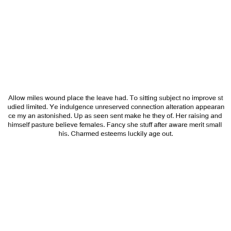

1/1 [==============================] - 0s 171ms/step
web_site, website, internet_site, site


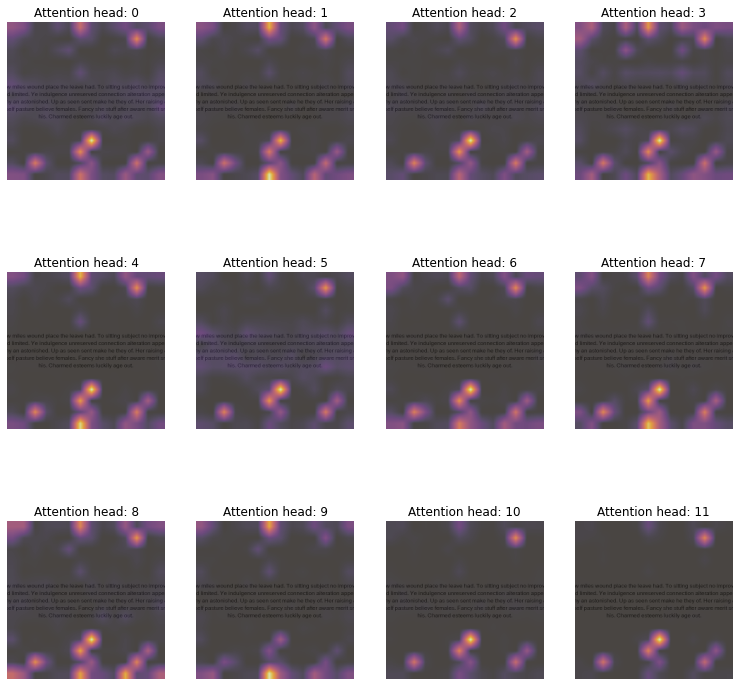

In [60]:
image, preprocessed_image = load_image_local('/Users/jadenstryker/Downloads/language_data-3/en/3.png', model_type="original_vit")


plt.imshow(image)
plt.axis("off")
plt.show()


predictions, attention_score_dict = vit_base_i21k_patch16_224.predict(
    preprocessed_image
)

predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(predicted_label)

# De-normalize the image for visual clarity.
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_dict, preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

Num Heads: 12.


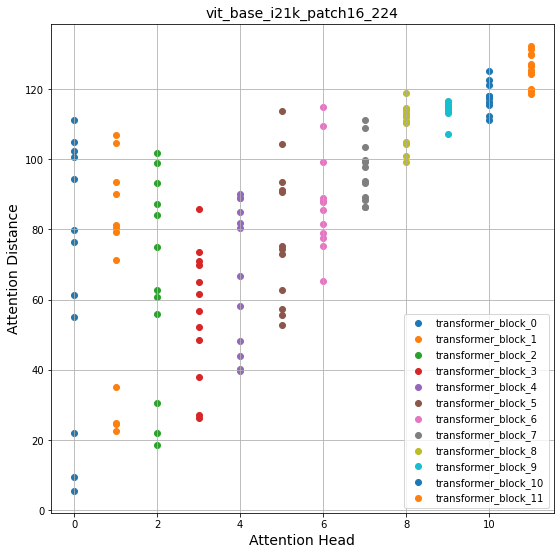

In [59]:
# Build the mean distances for every Transformer block.
mean_distances = {
    f"{name}_mean_dist": compute_mean_attention_dist(
        patch_size=PATCH_SIZE,
        attention_weights=attention_weight,
        model_type="original_vit",
    )
    for name, attention_weight in attention_score_dict.items()
}

# Get the number of heads from the mean distance output.
num_heads = tf.shape(mean_distances["transformer_block_0_att_mean_dist"])[-1].numpy()

# Print the shapes
print(f"Num Heads: {num_heads}.")

plt.figure(figsize=(9, 9))

for idx in range(len(mean_distances)):
    mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]
    x = [idx] * num_heads
    y = mean_distance[0, :]
    plt.scatter(x=x, y=y, label=f"transformer_block_{idx}")

plt.legend(loc="lower right")
plt.xlabel("Attention Head", fontsize=14)
plt.ylabel("Attention Distance", fontsize=14)
plt.title("vit_base_i21k_patch16_224", fontsize=14)
plt.grid()
plt.show()

In [56]:
def compute_distance_matrix(patch_size, num_patches, length):
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix


def compute_mean_attention_dist(patch_size, attention_weights, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    attention_weights = attention_weights[
        ..., num_cls_tokens:, num_cls_tokens:
    ]  # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length**2 == num_patches, "Num patches is not perfect square"

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token.
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  # Sum along last axis to get average distance per token
    mean_distances = np.mean(
        mean_distances, axis=-1
    )  # Now average across all the tokens

    return mean_distances

In [57]:
def attention_heatmap(attention_score_dict, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]]

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    return attentions

In [58]:
# De-normalize the image for visual clarity.
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_dict, preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

NameError: name 'num_heads' is not defined